# Experiments

### Paths

In [1]:
import sys

root_path = ".."  # top-level of the repository

sys.path.append(root_path)

### Setup

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

import os
from pathlib import Path
from tempfile import mkdtemp

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import canny
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, QuantileTransformer, PolynomialFeatures

from src.metrics import regression_report, regression_score
from src.fractal import compute_fractal_dimension
from src.utils import load_image_batch, sample_one, to_batch_function

In [4]:
sns.set()
plt.rcParams["figure.figsize"] = (16, 10)

In [5]:
cachedir = mkdtemp()  # for sklearn pipelines

# Dataset

In [6]:
mesurements_df = pd.read_csv("../data/dataset.csv")
mesurements_df.head(3)

,Sample,Hardness,File,Location,Code
0,1-101-2,129.9,../data/images/processed/1-101-2.jpg,top-right,1-101
1,1-101-4,130.0,../data/images/processed/1-101-4.jpg,bottom-left,1-101
2,1-102-2,137.6,../data/images/processed/1-102-2.jpg,top-right,1-102


Split dataset into train and test using sample code, to prevent information leakage.

In [7]:
train_codes, test_codes = train_test_split(mesurements_df["Code"].unique(), test_size=0.3, random_state=7)
len(train_codes), len(test_codes)

(176, 76)

In [8]:
train_df = mesurements_df.loc[mesurements_df["Code"].isin(train_codes)]
test_df = mesurements_df.loc[mesurements_df["Code"].isin(test_codes)]

train_images = load_image_batch(train_df["File"].tolist())
test_images = load_image_batch(test_df["File"].tolist())

# Ablation Study

First investigate the dependency of fractal dimension and hardness. <br>
Created plot is also in the paper.

In [9]:
def canny_filter(x):
    """Shorthand to use canny with non-default sigma value and to_batch_function wrapper"""
    return canny(x, sigma=0.8)

target_pipeline = Pipeline([
    ("scalar", StandardScaler()),
])

pipeline = Pipeline([
    ("color_to_grey", FunctionTransformer(rgb2gray)),
    ("canny", FunctionTransformer(to_batch_function(canny_filter))),
    ("fractal_dimension", FunctionTransformer(to_batch_function(compute_fractal_dimension))),
])

Compute fractal dimension for all training set.

In [10]:
features = pipeline.transform(train_images)
features.shape

(602, 1)

Manually fit the `LinearRegression` model to those computed fractal dimensions, without using pipeline. <br>
This is done to plot the feature-target dependency, as both are just a single number.

In [11]:
targets = target_pipeline.fit_transform(train_df["Hardness"].values.reshape(-1, 1))
model = LinearRegression(fit_intercept=True)
model = model.fit(features.reshape(-1, 1), targets)

Show the `a` and `b` coeffs of learned linear function. 

*Note*: Features are rescaled, so this is hard to interpret.

In [12]:
model.coef_, model.intercept_

(array([[16.25476257]]), array([-29.00764766]))

Compute predictions for the test set and rescale them back to original domain. 

In [13]:
predictions = model.predict(pipeline.transform(test_images))
predictions = target_pipeline.inverse_transform(predictions)

Print the `regression_report`, values should be the same as in `experiments.ipynb` 

In [14]:
print(regression_report(y_true=test_df["Hardness"].values, y_pred=predictions.flatten()))

                                Absolute                        Normalized                      

Mean Squared Error:             45.1667                         5.5826                          
Root Mean Squared Error:        6.7206                          0.8307                          
Mean Absolute Error:            5.1638                          0.6382                          
Median Absolute Error:          4.1153                          0.5086                          
Max Error:                      27.7682                         3.4321                          
R2                                                              0.3100                          


                                True                            Predicted                       

Mean:                           136.9574                        137.4277                        
std:                            8.0907                          3.8298                          



Plot the dependency and the dataset

In [15]:
x = np.linspace(1.5, 2.0, 25)  # sample syntetic fractal dimensions to generate plot
trendline = target_pipeline.inverse_transform(model.predict(x.reshape(-1,1)))
test_features = pipeline.transform(test_images)  # compute predictions for fractal values

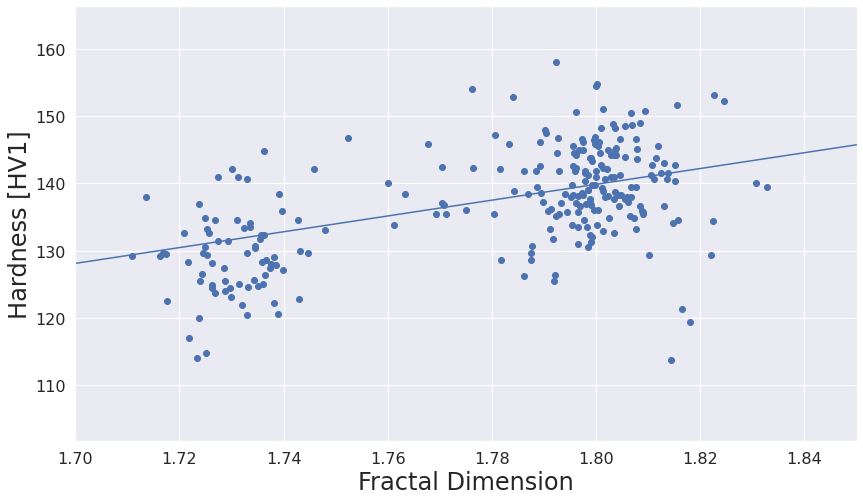

In [16]:
_ = plt.figure(figsize=[14, 8])
_ = plt.scatter(test_features, test_df["Hardness"])
_ = plt.plot(x, trendline)
_ = plt.xlim([1.7, 1.85])
_ = plt.ylabel("Hardness [HV1]", fontsize=24)
_ = plt.xlabel("Fractal Dimension", fontsize=24)
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)
# uncomment to overwrite
# _ = plt.savefig("../data/plots/fd-hv.png", bbox_inches="tight")

# Examples

Show examples of image with low and high estimated fractal dimension.

In [17]:
train_df["Hardness"].max(), train_df["Hardness"].min()

(162.0, 108.9)

In [18]:
feature_series = pd.Series(features.flatten())
# sample lowest and highest fractal dimension 
min_max_samples = feature_series.loc[(feature_series.max() == feature_series) | (feature_series.min() == feature_series)]
# predict fractal dimension for those samples
pred_hardness = target_pipeline.inverse_transform(model.predict(min_max_samples.values.reshape(-1, 1))).flatten().tolist()
# select hardness for those samples from dataset
true_hardness = train_df["Hardness"].iloc[[sample_id for sample_id in min_max_samples.index]].tolist()

Display statistics for examples

In [19]:
df = pd.DataFrame.from_records([
    min_max_samples.values.tolist(),
    pred_hardness,
    true_hardness,
]).transpose()

df.columns = ["Fractal Dimension", "Predicted Hardness", "Measured Hardness"]
df.applymap(lambda value: round(value, 2))

,Fractal Dimension,Predicted Hardness,Measured Hardness
0,1.84,144.08,127.8
1,1.71,129.41,134.4


In [20]:
canny_pipeline = Pipeline([
    ("color_to_grey", FunctionTransformer(rgb2gray)),
    ("canny", FunctionTransformer(to_batch_function(canny))),
])

pictures = canny_pipeline.transform(np.stack([train_images[sample_id] for sample_id in min_max_samples.index]))

Display image representation after canny filter

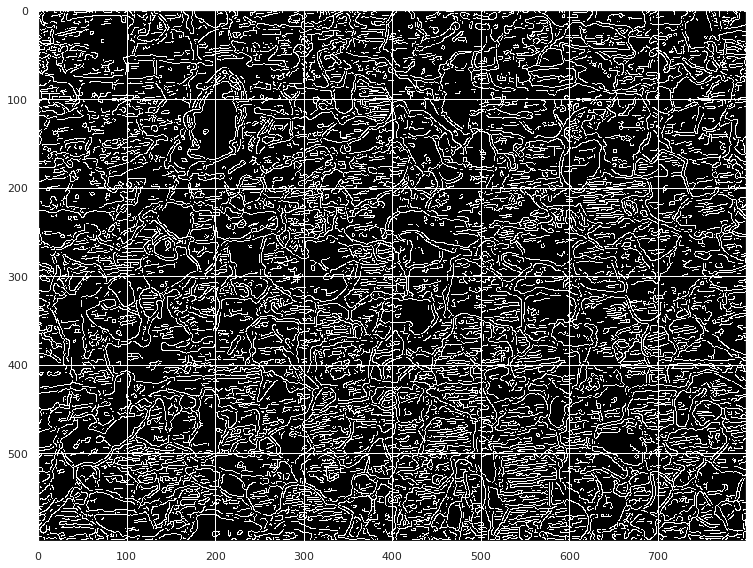

In [21]:
_ = plt.figure(figsize=[14,8])
_ = io.imshow(pictures[0,:,:])
# uncomment to overwrite
# _ = plt.savefig("../data/plots/high-hardness.png", bbox_inches="tight")

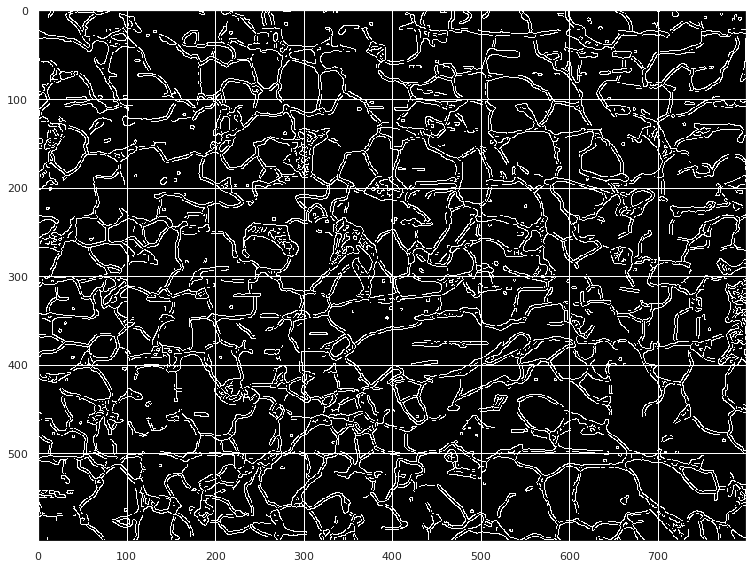

In [22]:
_ = plt.figure(figsize=[14,8])
_ = io.imshow(pictures[1,:,:])
# uncomment to overwrite
# _ = plt.savefig("../data/plots/low-hardness.png", bbox_inches="tight")

# Sigma Ablation

Test different values of `sigma` parameter of the Canny edge detector preceeding the fractal dimension computation. <br>
This analysis was used to select `sigma=0.8`, for which results are reported. <br>

*Warning*: Runtime of the cell below is ~30-40 minutes on typical CPU.

In [ ]:
results = {}

for sigma in np.arange(0.1, 3.5, 0.1).tolist():
    def canny_filter(image):
        """
        Dynamic shorthand to use canny with non-default sigma value and to_batch_function wrapper
        Could be redesigned, but the function to_batch_funtion did not assume input functions with parameters
        """
        return canny(image, sigma=sigma)
    
    # new instance in each loop
    target_pipeline = Pipeline([
        ("scalar", StandardScaler()),
    ])

    pipeline = Pipeline([
        ("color_to_grey", FunctionTransformer(rgb2gray)),
        ("canny", FunctionTransformer(to_batch_function(canny_filter))),
        ("fractal_dimension", FunctionTransformer(to_batch_function(compute_fractal_dimension))),
        ("model", TransformedTargetRegressor(LinearRegression(), transformer=target_pipeline))
    ])
    
    pipeline = pipeline.fit(train_images, train_df["Hardness"].values)
    predictions = pipeline.predict(test_images)
    
    results[sigma] = regression_score(y_true=test_df["Hardness"].values, y_pred=predictions.flatten())
    
# results_df = pd.DataFrame.from_dict(results).transpose()

In [23]:
results_df = pd.read_csv(r"../data/ablations/canny-sigma-ablation.csv")
# show 5 best results
results_df.sort_values(by="MDE", ascending=True)[["sigma", "MDE", "MAE", "Predicted Std"]].head().applymap(lambda value: round(value, 2))

,sigma,MDE,MAE,Predicted Std
7,0.8,4.12,5.16,3.83
8,0.9,4.15,5.21,3.75
11,1.2,4.31,5.45,3.48
9,1.0,4.31,5.29,3.67
6,0.7,4.32,5.16,3.86


Plot reported in the paper does not connecting line.

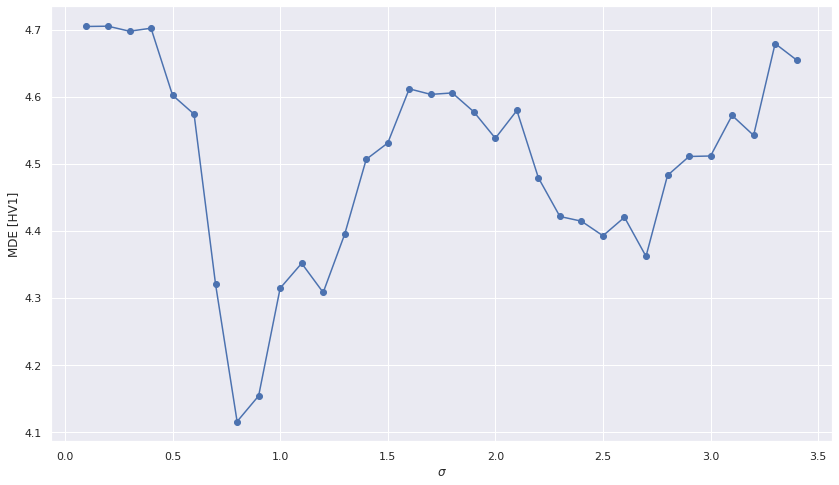

In [24]:
_ = plt.figure(figsize=[14,8])
_ = plt.scatter(x=results_df["sigma"].values, y=results_df["MDE"].values)
_ = plt.xlabel("$\sigma$")
_ = plt.ylabel("MDE [HV1]")
_ = plt.plot(results_df["sigma"].values, results_df["MDE"].values)
# uncomment to overwrite
# _ = plt.savefig("../data/plots/canny-sigma-ablation.png", bbox_inches="tight")

# Polynomial Feature Ablation

Ablation adding higher powers of fractal dimensions as featurs to the model. <br>
The results are compued for previously established `sigma=0.8`.

It turns out, that polynomial features do not bring, much benefit, but potentially could be useful with different datasets.

In [ ]:
results = {}

def canny_filter(image):
        return canny(image, sigma=0.8)

for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    target_pipeline = Pipeline([
        ("scalar", StandardScaler()),
    ])

    pipeline = Pipeline([
        ("color_to_grey", FunctionTransformer(rgb2gray)),
        ("canny", FunctionTransformer(to_batch_function(canny_filter))),
        ("fractal_dimension", FunctionTransformer(to_batch_function(compute_fractal_dimension))),
        ("poly", PolynomialFeatures(degree=degree)),
        ("model", TransformedTargetRegressor(LinearRegression(), transformer=target_pipeline))
    ])
    
    pipeline = pipeline.fit(train_images, train_df["Hardness"].values)
    predictions = pipeline.predict(test_images)
    
    results[degree] = regression_score(y_true=test_df["Hardness"].values, y_pred=predictions.flatten())

results_df = pd.DataFrame.from_dict(results).transpose()

In [25]:
results_df = pd.read_csv(r"../data/ablations/polynomial-features-ablation.csv")
results_df.sort_values(by="MDE", ascending=True)[["degree", "MDE", "MAE", "Predicted Std"]].head().applymap(lambda value: round(value, 3))

,degree,MDE,MAE,Predicted Std
0,1,4.115,5.164,3.830
7,8,4.124,5.118,4.520
2,3,4.149,5.156,4.059
3,4,4.158,5.143,4.074
9,10,4.173,5.120,4.514


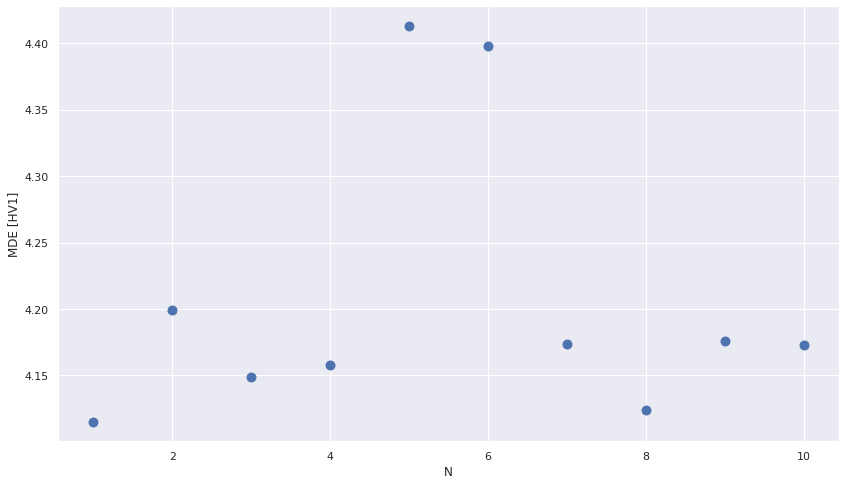

In [26]:
_ = plt.figure(figsize=[14,8])
_ = plt.scatter(x=results_df["degree"].values, y=results_df["MDE"].values, s=80)
_ = plt.xlabel("N")
_ = plt.ylabel("MDE [HV1]")
# uncomment to overwrite
# _ = plt.savefig("../data/plots/polynomial-features-ablation.png", bbox_inches="tight")

# Downstream Model Ablation

Changing the final model into different than `LinearRegression`. <br>
This ablation should support the hyphothesis that models with smaller number of fittable parameters will be more robust.

In [ ]:
results = {}

def canny_filter(image):
        return canny(image, sigma=0.8)

for ModelClass in [LinearRegression, GaussianProcessRegressor, SVR, MLPRegressor]:
    target_pipeline = Pipeline([
        ("scalar", StandardScaler()),
    ])

    pipeline = Pipeline([
        ("color_to_grey", FunctionTransformer(rgb2gray)),
        ("canny", FunctionTransformer(to_batch_function(canny_filter))),
        ("fractal_dimension", FunctionTransformer(to_batch_function(compute_fractal_dimension))),
        ("model", TransformedTargetRegressor(ModelClass(), transformer=target_pipeline))
    ])
    
    pipeline = pipeline.fit(train_images, train_df["Hardness"].values)
    predictions = pipeline.predict(test_images)
    
    results[ModelClass.__name__] = regression_score(y_true=test_df["Hardness"].values, y_pred=predictions.flatten())

The results on tested model, show that simpler models are better on the test set. <br>
This supports our hypothesis, that linear models using single feature will be best for this task.

However, valiation was performed using only one data-set, so this is not fully conclusive. <br>
It could be the case, that models evaluated using different features etc. achieve better results. <br>

Additionally experiments were performed using otsu-based index and 2-point correlation and no-result obtained was better then reported
for the linear model using fractal dimension.

In [27]:
def round_if_float(item):
    if item is float:
        return round(item, 2)
    return item

results_df = pd.read_csv(r"../data/ablations/downstream-model-ablation.csv")
results_df.sort_values(by="MDE", ascending=True)[["model", "MDE", "MAE", "Predicted Std"]].applymap(round_if_float)

,model,MDE,MAE,Predicted Std
0,LinearRegression,4.115295,5.163822,3.829756
1,GaussianProcessRegressor,4.145088,5.154966,4.060384
2,SVR,4.270516,5.207152,3.545828
3,MLPRegressor,5.463594,6.609121,0.034624
